original_dag has 1 connected components
cut_dag has 2 connected components


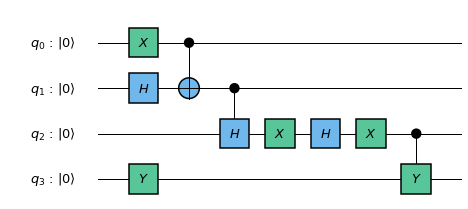

In [23]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import *
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
from qiskit.extensions.standard import CHGate, HGate, CnotGate, CyGate, CzGate
from qiskit.circuit import Measure
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
from qiskit import *
import numpy as np
import itertools
import networkx as nx
import pickle
from help_fun import cut_edge

q = QuantumRegister(4, 'q')
# c = ClassicalRegister(4, 'c')
circ = QuantumCircuit(q)
circ.h([q[2],q[1]])
circ.x([q[2],q[0]])
circ.y(q[3])
circ.cx(q[0], q[1])
circ.cy(q[2], q[3])
circ.ch(q[1], q[2])
circ.x(q[2])
# circ.barrier()
# circ.measure(q,c)
circ.draw()

original_dag = circuit_to_dag(circ)
print('original_dag has %d connected components' % nx.number_weakly_connected_components(original_dag._multi_graph))
# print(nx.algorithms.connectivity.cuts.minimum_edge_cut(dag._multi_graph))
dag_drawer(original_dag, filename='original_dag.pdf')
circ.draw(output='mpl',filename='original_circ.pdf')

cut_dag = cut_edge(original_dag=original_dag, wire=q[2],source_node_name='cy', dest_node_name='ch')
print('cut_dag has %d connected components' % nx.number_weakly_connected_components(cut_dag._multi_graph))
dag_drawer(cut_dag, filename='cut_dag.pdf')
dag_to_circuit(cut_dag).draw(output='mpl',filename='cut_circ.pdf')

In [32]:
wire_being_cut = q[2]
num_components = nx.number_weakly_connected_components(cut_dag._multi_graph)
for i in range(num_components):
    sub_circ = QuantumCircuit()
    print('component %d' % i)
    component = list(nx.weakly_connected_components(cut_dag._multi_graph))[i]
    
    """Add appropriate registers"""
    reg_dict = {}
    contains_cut_q_out_node = False
    for node in cut_dag.topological_nodes():
        if node in component:
            if node.type == 'in':
                if node.wire.register.name not in reg_dict:
                    reg_dict[node.wire.register.name] = 1
                else:
                    reg_dict[node.wire.register.name] += 1
            elif node.type == 'out' and node.name == '%s[%s]' %(wire_being_cut.name, wire_being_cut.index):
                contains_cut_q_out_node = True
    if contains_cut_q_out_node:
        reg_dict['cutQ'] = 1
    print(reg_dict)
    for key in reg_dict:
        q_reg = QuantumRegister(reg_dict[key], key)
        sub_circ.add_register(q_reg)
        
    """Change qargs"""
    for node in cut_dag.topological_nodes():
        if node in component:
            node.qargs = [cutQ[0] if x==original_node else x for x in node.qargs]
            print(node.type, node.name, node.qargs, node.cargs)
    dag_drawer(circuit_to_dag(sub_circ), filename='sub_dag_%d.pdf' % i)
    print('finished component %d' % i)
    break

component 0
{'q': 2, 'cutQ': 1}
in q[0] [] []
op x [Qubit(QuantumRegister(4, 'q'), 0)] []
in q[1] [] []
op h [Qubit(QuantumRegister(4, 'q'), 1)] []
op cx [Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1)] []
op ch [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2)] []
op x [Qubit(QuantumRegister(4, 'q'), 2)] []
out q[0] [] []
out q[1] [] []
out q[2] [] []
finished component 0


wire: Qubit(QuantumRegister(4, 'q'), 0)
in(q[0])
op(x)
op(cx)
out(q[0])

wire: Qubit(QuantumRegister(4, 'q'), 1)
in(q[1])
op(h)
op(cx)
op(ch)
out(q[1])

wire: Qubit(QuantumRegister(4, 'q'), 2)
in(q[2])
op(h)
op(x)
op(cy)
op(measure)
out(q[2])

wire: Qubit(QuantumRegister(4, 'q'), 3)
in(q[3])
op(y)
op(cy)
out(q[3])

wire: Qubit(QuantumRegister(1, 'cutQ'), 0)
in(cutQ[0])
op(ch)
op(x)
out(cutQ[0])

wire: Clbit(ClassicalRegister(1, 'cutC'), 0)
in(cutC[0])
op(measure)
out(cutC[0])

manual_dag has 2 connected components


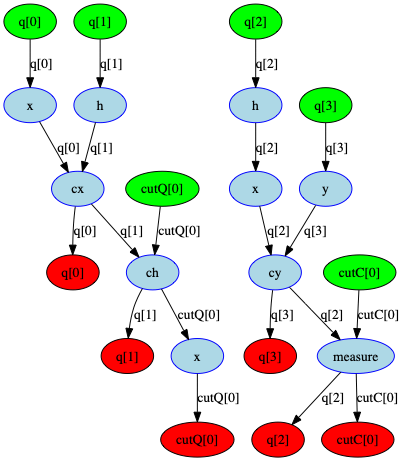

In [5]:
q = QuantumRegister(4, 'q')
cutQ = QuantumRegister(1, 'cutQ')
cutC = ClassicalRegister(1, 'cutC')
manual_circ = QuantumCircuit(q,cutQ,cutC)

manual_circ.h([q[1],q[2]])
manual_circ.x([q[0],q[2]])
manual_circ.y(q[3])
manual_circ.cx(q[0],q[1])
manual_circ.cy(q[2],q[3])
manual_circ.ch(q[1],cutQ[0])
manual_circ.measure(q[2],cutC[0])
manual_circ.x(cutQ[0])
manual_dag = circuit_to_dag(manual_circ)

manual_circ.draw(output='mpl')
for wire in manual_dag.wires:
    print('wire:', wire)
    [print('%s(%s)' % (x.type, x.name)) for x in manual_dag.nodes_on_wire(wire)]
    print()
print('manual_dag has %d connected components' % nx.number_weakly_connected_components(manual_dag._multi_graph))
dag_drawer(manual_dag)